In [1]:
import sys
sys.path.append("../../")
DATA_PATH = "../../data/"
SAVE_PATH = "../../plots"

import matplotlib.pyplot as plt
import numpy as np
import py_common.utility as utility
from py_common.units import *
from py_common.scattering_dependence import *
from py_common.bounds_dependence import *
from py_common.wave_function import *
from matplotlib.collections import LineCollection
import itertools
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from py_common.utility import AxesArray
from ipywidgets import interact
import pickle

plt.rcParams.update({'font.size': 18})

n_colors = ["#FF0088", "#00FF9D", "#0BA6FF", "#8C0AE2"]
BINS = [-0.246, -1.660, -5.280]
ROT_CONST = 0.24975935 * CMINV / GHZ

reference_singlet = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet.dat")
reference_singlet_scaled_1 = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet_scaled_1.dat")

reference_triplet = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet.dat")
reference_triplet_scaled_1 = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet_scaled_1.dat")

colors = ["red", "green", "blue", "purple", "navy", "black"]

def bounds_loss(bounds, bounds_true):
    chi = 0
    for i, b in enumerate(bounds_true):
        if i >= len(bounds):
            chi += 1
        else:
            chi += (np.log2(bounds[i] / b))**2
    chi /= i # type: ignore
    
    return chi

def bounds_losses(bounds, bounds_true):
    fields = np.unique(bounds.data[:, 0])

    losses = []
    for bounds_single in bounds.fields():
        losses.append(bounds_loss(bounds_single[:, 1], bounds_true))

    return np.array([np.array(fields), np.array(losses)])

def plot_bounds(ax: Axes, bounds: BoundsDependence, x_scaled = lambda x: x):
    for state in bounds.states():
        points = np.column_stack([x_scaled(state[:, 0]), np.cbrt(state[:, 1])])
        segments = np.stack([points[:-1], points[1:]], axis=1)
        colors = np.column_stack([state[:, 2], state[:, 3], state[:, 4]])
        
        lc = LineCollection(segments, colors=colors[:-1]) # type: ignore
        
        ax.add_collection(lc)

def plot_2d_bounds(
        bound_dependence: BoundsDependence2D, 
        reference: npt.NDArray[np.float64], 
        axis: int = 1, 
        c6_mult = 1.,
        label = "scaling view factor ="
) -> tuple[Figure, AxesArray]:
    fig, axes = utility.plot_many(1, 2, shape=(15, 5), sharex = True)

    def update(scaling_index = 0):
        for art in list(axes[0].lines):
            art.remove()
        for art in list(axes[0].collections):
            art.remove()

        bounds_index, scaling_view = bound_dependence.slice(scaling_index, axis)

        for state in bounds_index.states():
            if state.shape[1] == 3:
                axes[0].plot(state[:, 0], np.cbrt(state[:, 1]), color="blue")
            else:
                points = np.column_stack([state[:, 0], np.cbrt(state[:, 1])])
                segments = np.stack([points[:-1], points[1:]], axis=1)
                colors = np.column_stack([state[:, 2], state[:, 3], state[:, 4]])

                lc = LineCollection(segments, colors=colors[:-1]) # type: ignore
                
                axes[0].add_collection(lc)

        for b in reference:
            axes[0].axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

        for b in BINS:
            axes[0].axhline(np.cbrt(b / c6_mult**0.5), color = "black", linestyle="--", linewidth=0.5)

        for art in list(axes[1].lines):
            art.remove()

        chi2 = bounds_losses(bounds_index, reference)
        axes[1].plot(chi2[0, :], chi2[1, :], color = "blue")

        fig.suptitle(f"{label} {scaling_view:.4f}")

        fig.canvas.draw_idle()
    
    update(scaling_index=0)

    interact(update, scaling_index = (0, bound_dependence.slice_len(axis) - 1))

    return fig, axes

@dataclass
class WKBLevel:
    n: int
    slope: float
    energy_diss: float
    intercept: float

    def levels_cbrt(self, lambd):
        return np.cbrt(self.energy_diss - np.power(self.slope * (np.sqrt(lambd) - self.intercept), 3) / np.sqrt(lambd))

class WKBLevels:
    levels: list[WKBLevel]
    slope: float
    rot_const: float
    spacing: float
    range_lambda: tuple[float, float]
    range_level_cbrt: tuple[float, float]

    def __init__(self, slope: float, rot_const: float, spacing: float, range_lambda: tuple[float, float], range_level_cbrt: tuple[float, float]):
        self.levels = []
        self.slope = slope
        self.rot_const = rot_const
        self.spacing = spacing
        self.range_lambda = range_lambda
        self.range_level_cbrt = range_level_cbrt

    # @staticmethod
    # def from_n_0(self, first, range_lambda: tuple[float, float], range_level_cbrt: tuple[float, float]) -> 'WKBLevels':
    #    pass

    def add_level_cbrt(self, n: int, point: tuple[float, float], slope: float | None = None, spacing: float | None = None):
        spacing = spacing if spacing is not None else self.spacing
        slope = slope if slope is not None else self.slope

        assert point[0] >= self.range_lambda[0] and point[0] <= self.range_lambda[1]
        assert point[1] >= self.range_level_cbrt[0] and point[1] <= self.range_level_cbrt[1]

        energy_diss = n * (n + 1) * self.rot_const
        intercept = np.cbrt(point[1]**3 * np.sqrt(point[0]) - energy_diss) / slope + np.sqrt(point[0])

        lowest_intercept = np.cbrt(self.range_level_cbrt[0]**3 * np.sqrt(self.range_lambda[0]) - energy_diss) / slope + np.sqrt(self.range_lambda[0])
        highest_intercept = np.cbrt(self.range_level_cbrt[1]**3 * np.sqrt(self.range_lambda[1]) - energy_diss) / slope + np.sqrt(self.range_lambda[1])

        k_min = int(np.ceil((lowest_intercept - intercept) / spacing))
        k_max = int(np.floor((highest_intercept - intercept) / spacing))

        for k in range(k_min, k_max + 1):
            self.levels.append(WKBLevel(n, slope, energy_diss, intercept + k * spacing))


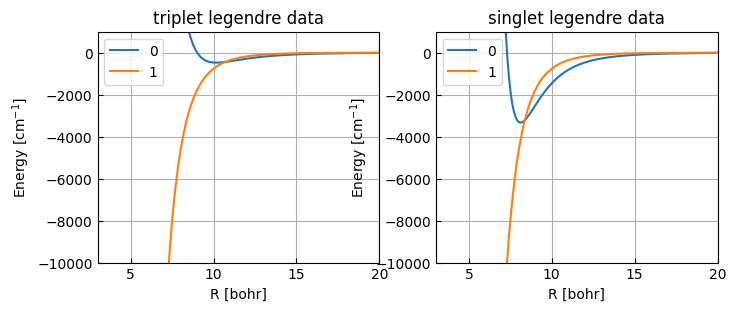

In [44]:
files = [
    "rotor_atom_model_triplet_dec.dat",
    "rotor_atom_model_singlet_dec.dat",
]

titles = [
    "triplet legendre data",
    "singlet legendre data",
]

fig, axes = utility.plot_many(1, 2, (8, 3))

for i, ax in enumerate(axes):
    data = utility.load(f"{DATA_PATH}/{files[i]}")
    scalings = data[:, 0]
    values_legendre = data[:, 1:]

    ax.plot(scalings, values_legendre / CMINV)
    ax.legend([str(i) for i in range(5)])
    ax.set_title(titles[i])
    ax.set_xlabel("R [bohr]")
    ax.set_ylabel(r"Energy [cm$^{-1}$]")

    ax.set_xlim(3, 20)
    ax.set_ylim(-10000, 1000)
    

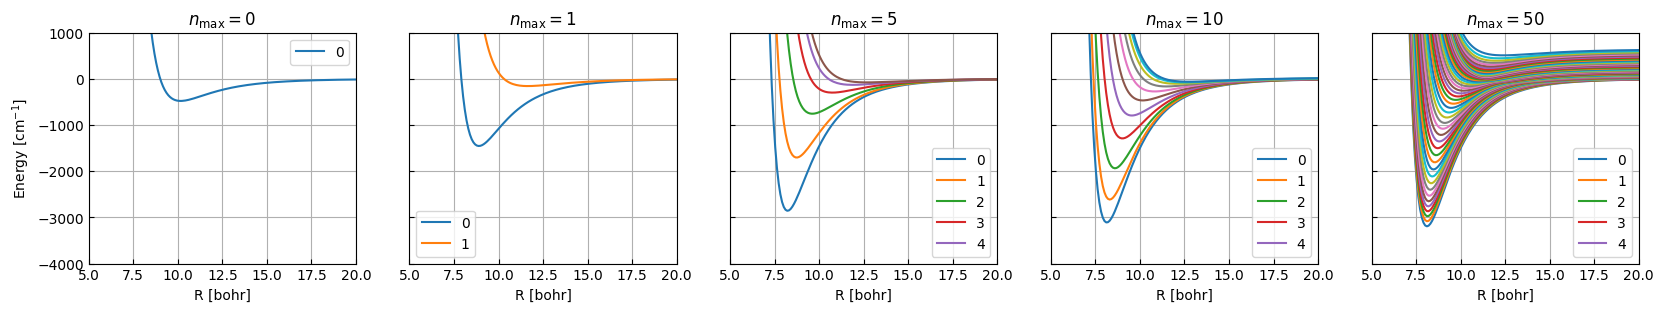

In [53]:
n_maxes = [0, 1, 5, 10, 50]

fig, axes = utility.plot_many(1, 5, (20, 3), sharey=True)

for i, ax in enumerate(axes):
    data = utility.load(f"{DATA_PATH}/rotor_atom_model_triplet_adiabat_n_{n_maxes[i]}.dat")
    scalings = data[:, 0]
    values_legendre = data[:, 1:]

    ax.plot(scalings, values_legendre / CMINV)
    ax.legend([str(i) for i in range(5)])
    ax.set_title(r"$n_\text{max}" + f" = {n_maxes[i]}$")
    ax.set_xlabel("R [bohr]")

    ax.set_xlim(5, 20)
    ax.set_ylim(-4000, 1000)
axes[0].set_ylabel(r"Energy [cm$^{-1}$]");

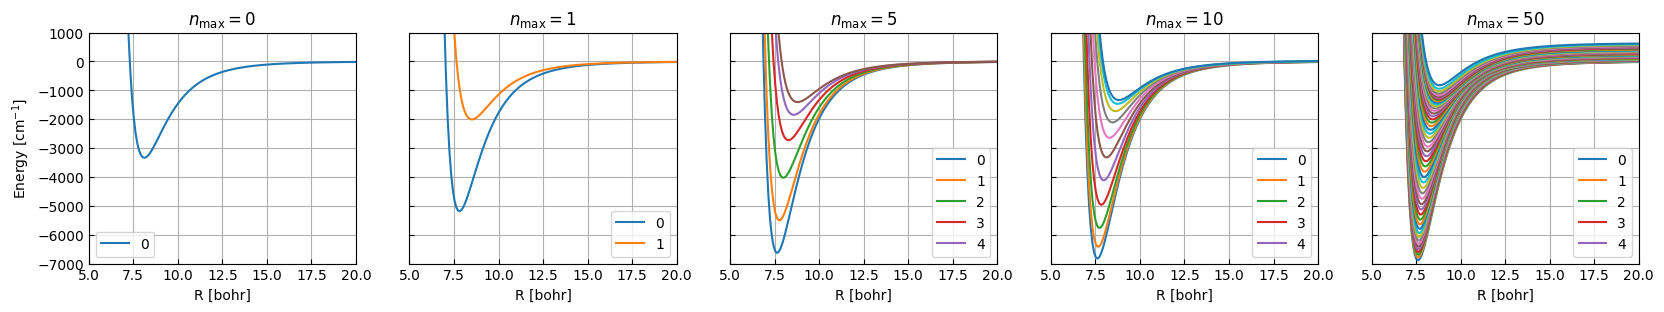

In [54]:
n_maxes = [0, 1, 5, 10, 50]

fig, axes = utility.plot_many(1, 5, (20, 3), sharey=True)

for i, ax in enumerate(axes):
    data = utility.load(f"{DATA_PATH}/rotor_atom_model_singlet_adiabat_n_{n_maxes[i]}.dat")
    scalings = data[:, 0]
    values_legendre = data[:, 1:]

    ax.plot(scalings, values_legendre / CMINV)
    ax.legend([str(i) for i in range(5)])
    ax.set_title(r"$n_\text{max}" + f" = {n_maxes[i]}$")
    ax.set_xlabel("R [bohr]")

    ax.set_xlim(5, 20)
    ax.set_ylim(-7000, 1000)
axes[0].set_ylabel(r"Energy [cm$^{-1}$]");

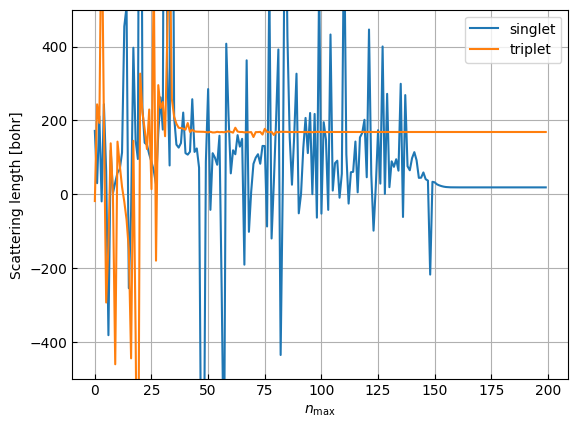

In [59]:
data = utility.load(f"{DATA_PATH}/rotor_atom_model_pes_scattering_convergence.dat")

fig, ax = utility.plot()
ax.plot(data[:, 0], data[:, 1])
ax.plot(data[:, 0], data[:, 2])

ax.set_ylim(-500, 500)
ax.set_xlabel(r"$n_\text{max}$")
ax.set_ylabel("Scattering length [bohr]")
ax.legend(["singlet", "triplet"]);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_n_10.pdf")

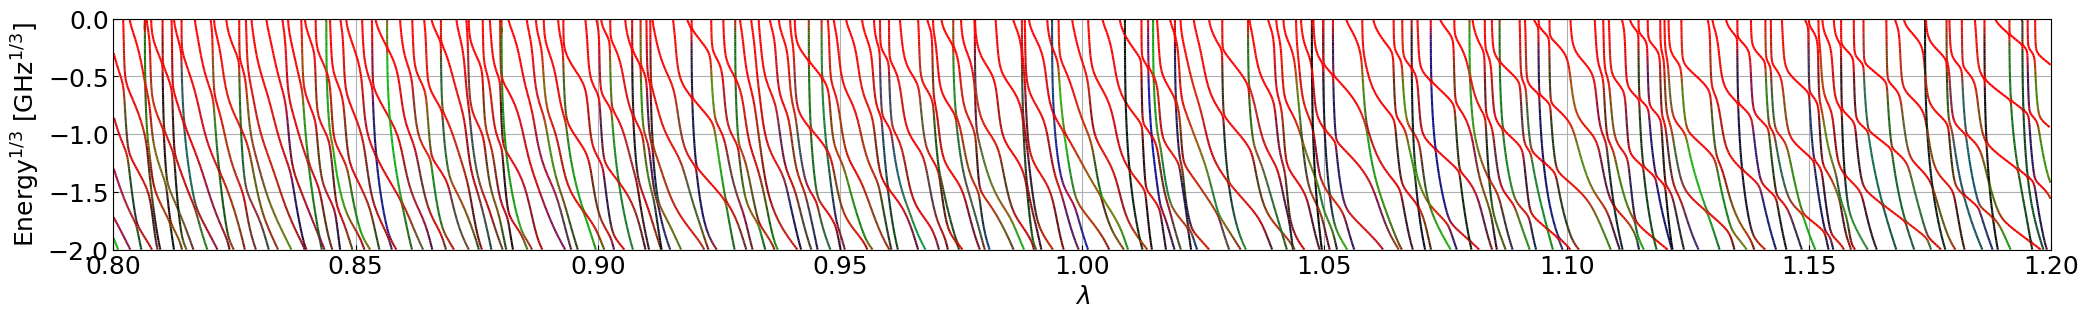

In [11]:
fig, ax = utility.plot(shape = (25, 3))

plot_bounds(ax, BoundsDependence.parse_field_json(f"{DATA_PATH}/rotor_atom_model_singlet_scaling_n_max_10.json"))


ax.set_ylabel(f"Energy$^{{1/3}}$ [GHz$^{{1/3}}$]")
ax.set_ylim(-2, 0)
ax.set_xlim(0.8, 1.2)
ax.set_xlabel(r"$\lambda$");

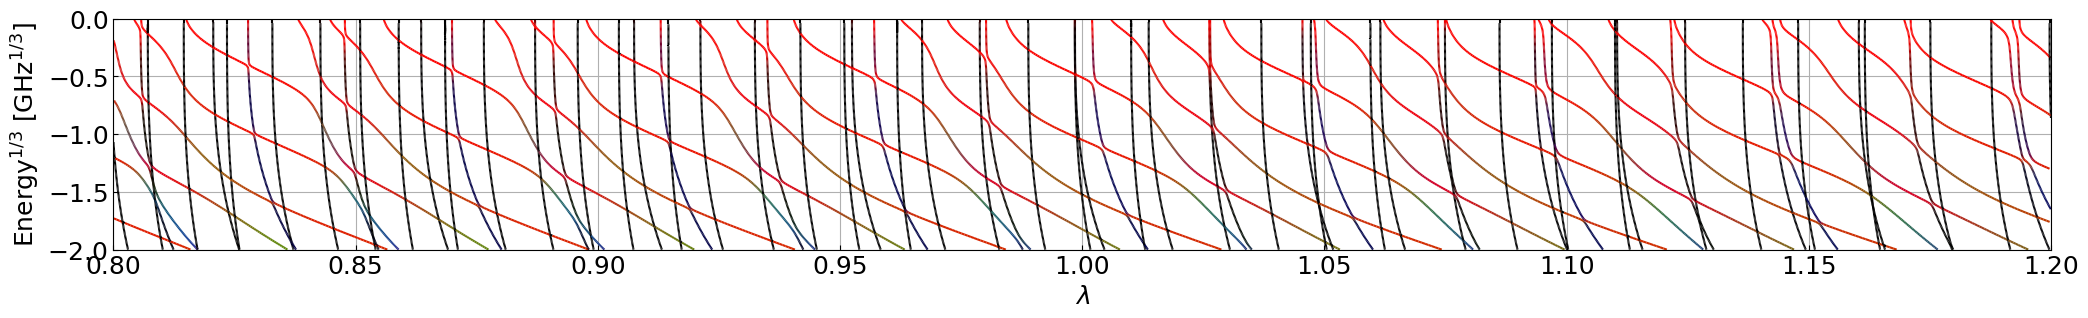

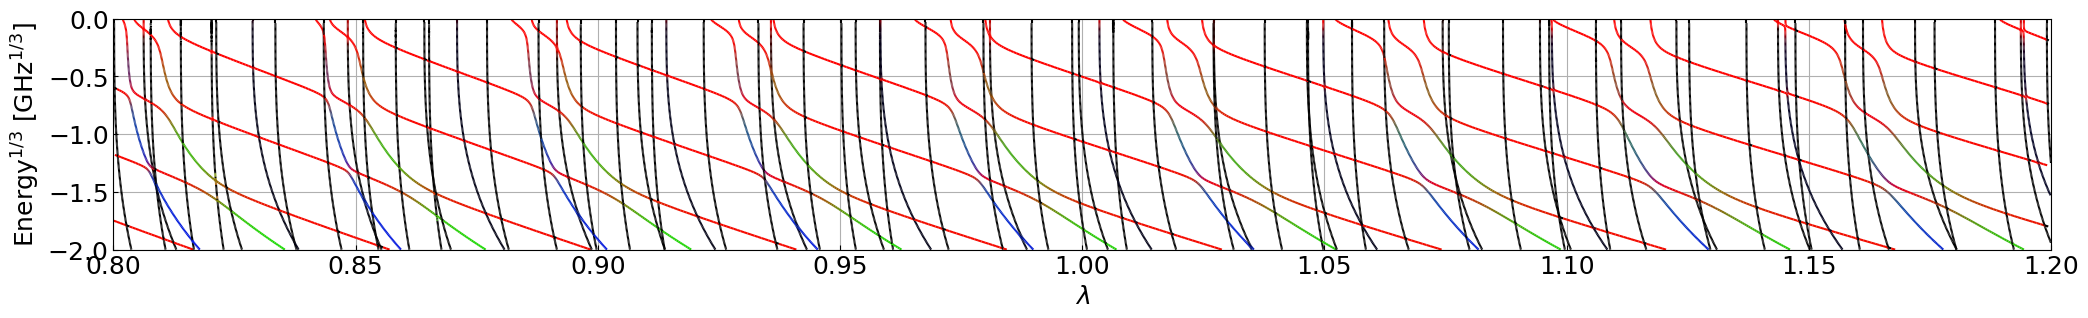

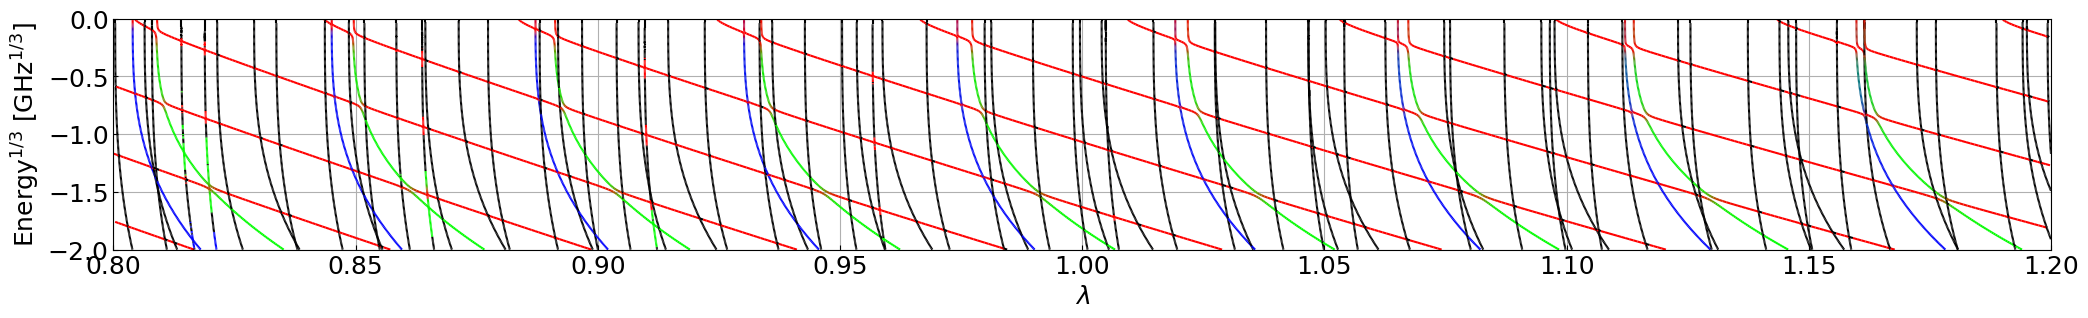

In [19]:
suffixes = ["_anisotropy_1e-2", "_anisotropy_5e-3", "_anisotropy_1e-3"]

for suffix in suffixes:
    fig, ax = utility.plot(shape = (25, 3))

    plot_bounds(ax, BoundsDependence.parse_field_json(f"{DATA_PATH}/rotor_atom_model_triplet_scaling_n_max_10{suffix}.json"))

    ax.set_ylabel(f"Energy$^{{1/3}}$ [GHz$^{{1/3}}$]")
    ax.set_ylim(-2, 0)
    ax.set_xlim(0.8, 1.2)
    ax.set_xlabel(r"$\lambda$");


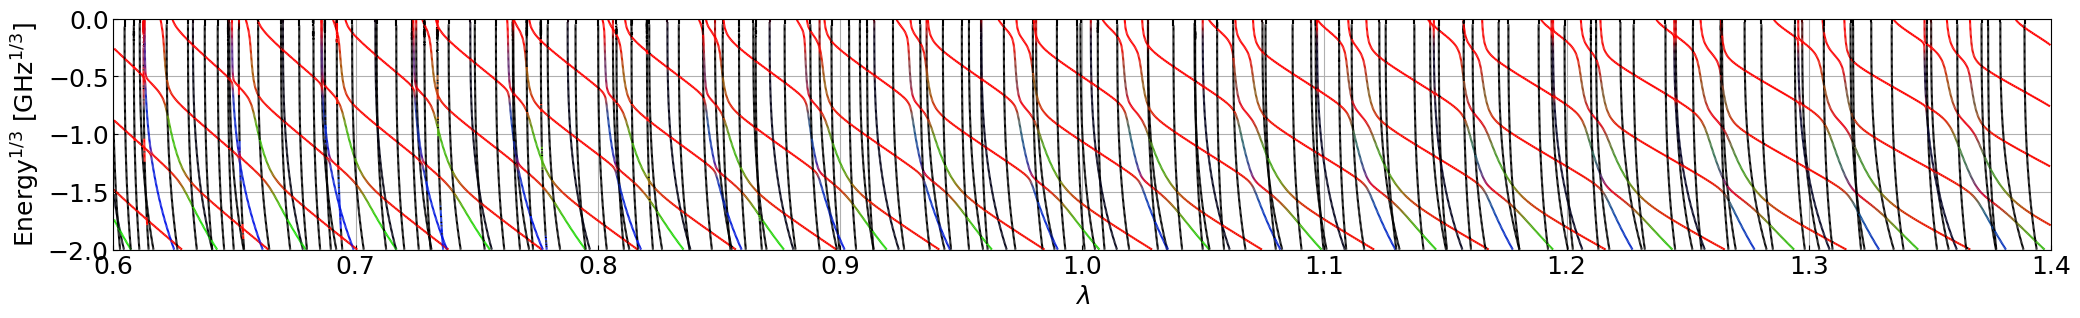

In [21]:
fig, ax = utility.plot(shape = (25, 3))

plot_bounds(ax, BoundsDependence.parse_field_json(f"{DATA_PATH}/rotor_atom_model_triplet_scaling_n_max_10_anisotropy_5e-3_long.json"))

ax.set_ylabel(f"Energy$^{{1/3}}$ [GHz$^{{1/3}}$]")
ax.set_ylim(-2, 0)
ax.set_xlim(0.6, 1.4)
ax.set_xlabel(r"$\lambda$");

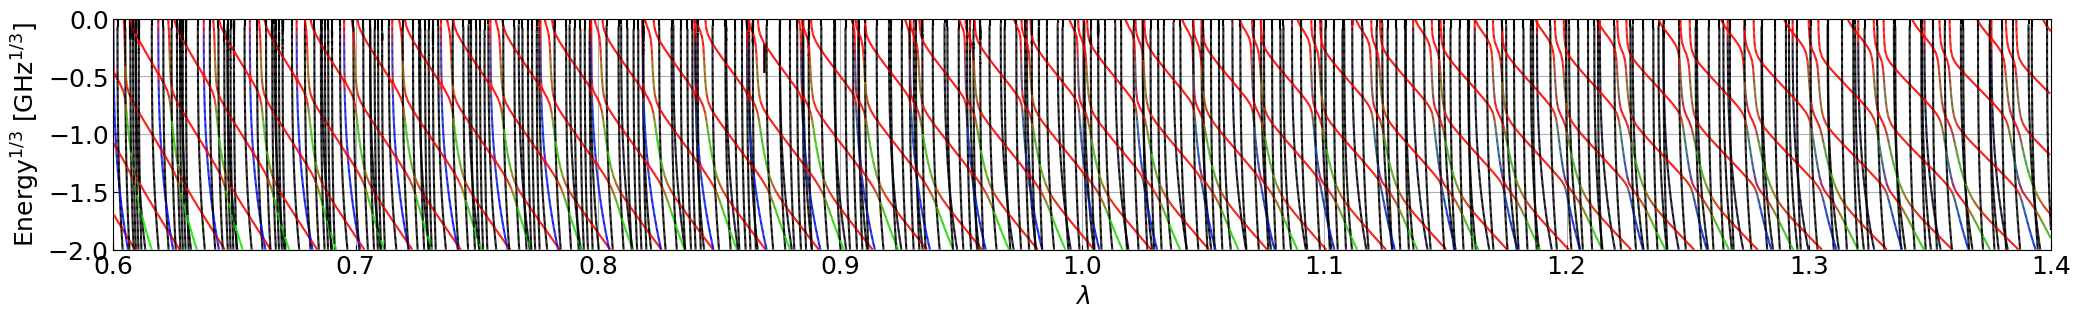

In [24]:
fig, ax = utility.plot(shape = (25, 3))

plot_bounds(ax, BoundsDependence.parse_field_json(f"{DATA_PATH}/rotor_atom_model_singlet_scaling_n_max_10_anisotropy_5e-3_long.json"))

ax.set_ylabel(f"Energy$^{{1/3}}$ [GHz$^{{1/3}}$]")
ax.set_ylim(-2, 0)
ax.set_xlim(0.6, 1.4)
ax.set_xlabel(r"$\lambda$");

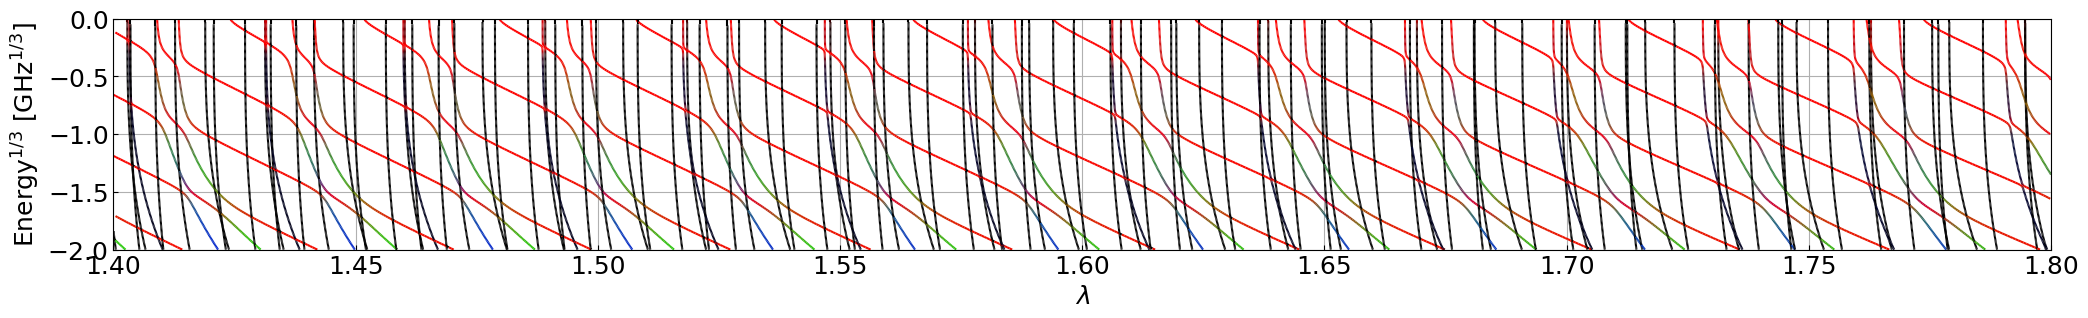

In [25]:
fig, ax = utility.plot(shape = (25, 3))

plot_bounds(ax, BoundsDependence.parse_field_json(f"{DATA_PATH}/rotor_atom_model_singlet_scaling_n_max_10_anisotropy_5e-3_scaling_1_4.json"))

ax.set_ylabel(f"Energy$^{{1/3}}$ [GHz$^{{1/3}}$]")
ax.set_ylim(-2, 0)
ax.set_xlim(1.4, 1.8)
ax.set_xlabel(r"$\lambda$");